In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Let $ \mathcal{T}_{X} = \{X_{i}, Y_{i}\}_{i = 1}^{n_{1}} \stackrel{iid}{\sim} F_{X,Y} $ and $ \mathcal{T}_{Z} = \{Z_{j}, W_{j}\}_{j=1}^{n_{2}} \stackrel{iid}{\sim} F_{Z,W} $. Suppose $ X_{i}, Z_{j} \in \mathcal{X} $ and $ Y_{i}, W_{j} \in \{0, 1\} $. For the sake of simplicity let $ n_{1} = n_{2} = n $, and $ \mathcal{X} = \mathbb{R} $. We refer to $ \mathcal{T}_{X} $ and $ \mathcal{T}_{Z} $ as training data. The goal of any classification procedure is to predict the class label of an unlabeled observation in the input space, $ X_{0} \in \mathcal{X} $. Though we do not introduce the necessary notational machinery, it is assumed that any classifier knows what distribution, $ F_{X, Y} $ or $ F_{Z, W} $, a particular test observation came from. In this write up we make the distinction via different letters (X and Z). 

In this notebook we investigate two types of classifiers. The first type ignores potentially useful information in $ \mathcal{T}_{Z} $ when classifying $ X_{0} \sim F_{X,Y} $ (and the same is true when classifying $ Z_{0} \sim F_{Z, W} $). The second type attempts to use information in both sets of training data. In particular, consider $ \hat{\eta}_{X}(\cdot) $ and $ \hat{\eta}_{Z}(\cdot) $, estimates of $ P_{Y=1|X}(Y=1|X) $ and $ P_{W=1|Z}(W=1|Z) $, respectively. 

The classifier we consider that is of the first type is simply Bayes', or, 
$$ \hat{Y}_{0} = g_{X}(X_{0} | \mathcal{T}_{X}, \mathcal{T}_{Z}) = \begin{cases} 1 \mbox{ if $ \hat{\eta}_{X}(X_{0}) > \frac{1}{2} $} \\ 0 \mbox{ o/w} \end{cases} $$ where $ g_{Z}(Z_{0} | \mathcal{T}_{X}, \mathcal{T}_{Z}) $ is defined analogously. 

We consider two classifiers of the second type. The first can be described as follows: Assume we are classifying a test observation from $ F_{X, Y} $. Estimate the posterior associated with $ X $, $ \hat{\eta}_{X} $. Then, using $ \mathcal{T}_{Z} $, partition $ \mathcal{X} $. Then use $ \mathcal{T}_{X} $ to estimate the posterior associated with $ X $ -- simply use the propotion of points in $ \mathcal{T}_{X} $ such that $ X_{i} $ is in the partition and $ Y_{i} = 1 $. Let $ \hat{\eta}_{Z,X} $ denote the posterior estimated from using the structure $ \mathcal{T}_{Z} $ for observations from $ F_{X, Y} $. A natural classifier from this procedure is given by 
$$ \hat{Y}_{0} = g_{X, L2M}(X_{0} | \mathcal{T}_{X}, \mathcal{T}_{Z}) = \begin{cases} 1 \mbox{ if $ \hat{\eta}_{X}(X_{0}) + \hat{\eta}_{X,Z}(X_{0}) > 1 $} \\ 0 \mbox{ o/w} \end{cases} $$ 

The second classifier uses $ \mathcal{T}_{Z} $ a bit differently. Let $$ \hat{\alpha}_{X} = \frac{\sum_{i=1}^{n} \left[ \mathbb{1}\{\hat{\eta}_{X}(X_{i}) > 0.5\} \mathbb{1}\{\hat{\eta}_{Z}(X_{i}) > 0.5\} + \mathbb{1}\{\hat{\eta}_{X}(X_{i}) < 0.5\} \mathbb{1}\{\hat{\eta}_{Z}(X_{i}) < 0.5\} \right]}{n} $$

Then consider the classifier $$ g_{X, cep}(X_{0} | \mathcal{T}_{X}, \mathcal{T}_{Z}) = \begin{cases} 1 \mbox{ if $ \hat{\eta}_{X}(X_{0}) + \hat{\alpha}_{X} \hat{\eta}_{Z}(X_{0}) > \frac{(1 + \hat{\alpha}_{X})}{2} $} \\ 0 \mbox{ otherwise} \end{cases} $$

Though i do not write it out, it is possible that $ F_{X,Y} $ and $ F_{W,Z} $ are such that $ \eta_{X}(X) = 1 - \eta_{Z}(X) $ for all $ X $. In such a case, there is a lot of information in $ \mathcal{T}_{Z} $ about $ F_{X, Y} $ that $ \hat{\alpha}_{X} $ is not able to take advantage of. To this point, one should permute the labels, $ W $, such that the sum is maximized. This is simply a label alignment. Note that the other two classifiers do not require this check.

The definition of $ \alpha_{X} $ is a global measure of similarity and, hence, for particular $ X \in \mathcal{X} $ it may be less (or more) beneficial to consider $ \eta_{Z} $ then a "typical" $ X \in \mathcal{X} $. For that reason, it may be beneficial to consider a local version of $ \alpha_{X} $, $$ \alpha_{k}(X) = \frac{\sum_{x \in \mathcal{N}_{k}(X)} \mathbb{1} \{g_{X}(x) = g_{Z}(x)\}}{k} $$ where $ \mathcal{N}_{k}(X) = \{x \in \mathcal{T}_{X}$ : $ x $ is one of $ X $ 's $ k $ nearest neighbors\}.

The first experiment to compare the classifiers is as follows:
Fix $ n = n_{1} = n_{2} $. Let $ f(X|Y=0) = f(Z|Y=1) = Uniform(0,1) $ and $ f(X|Y=1) = f(X|Y=0) = Uniform(1,2) $. Then $ L^{*}_{X} = L^{*}_{Z} = 0 $. 

To estimate posteriors, we use $ k = log(n) $ random partitions of $ \mathcal{X} $. 

In [3]:
def generate_sample(n, pi, conditional_0, params0, conditional_1, params1, acorn=None):
    if acorn is None:
        acorn = np.random.seed(10**6)
    np.random.seed(acorn)
    
    n0 = int(np.random.binomial(n, pi))
    n1 = n - n0
    ns = [n0, n1]
    
    X0 = conditional_0(*params0, size=n0)
    X0 = np.sort(X0[::])
    
    X1 = conditional_1(*params1, size=n1)
    X1 - np.sort(X1[::])
    
    labels = np.concatenate([i*np.ones(ns[i]) for i in range(len(ns))])
    
    return [[X0, X1], labels]

class LinearClassifier:
    def __init__(self, boundaries, boundary_left=-10**6, boundary_right=10**6):
        boundaries = np.sort(boundaries)[::]
        boundaries = np.concatenate(([boundary_left], boundaries, [boundary_right]))
        self.boundaries = boundaries
    
    def fit(self, X, y, finite_sample_correction=True):
        posteriors = np.zeros(len(self.boundaries) - 1)
        
        unique_labels, label_counts = np.unique(y, return_counts=True)
        K = len(unique_labels)
        
        for i in range(len(self.boundaries) - 1):
            temp_idx = ((X > self.boundaries[i]).astype(int) + (X < self.boundaries[i+1]).astype(int)) == 2
            temp = X[temp_idx]
            temp_labels = y[temp_idx]
            
            unique_, counts_ = np.unique(temp_labels, return_counts=True)
            
            if finite_sample_correction:
                correction = 1 / (K * len(temp_labels))
            
            if len(unique_) == 0:
                posteriors[i] = label_counts[-1] / np.sum(label_counts)
            elif len(unique_) == 2:
                posteriors[i] = counts_[-1] / np.sum(counts_)
            elif unique_[0] == 0:
                posteriors[i] = 0 + correction 
            else:
                posteriors[i] = 1 - correction

        self.posteriors = posteriors
        
    def predict(self, X, return_posteriors=False):
        posteriors = -1*np.ones(len(X))
        partitions = np.sum([np.array(X > c_) for c_ in self.boundaries], axis=0)
        for i, c_ in enumerate(self.boundaries[1:]):
            posteriors[np.where(partitions == i+1)] = self.posteriors[i]

        posteriors[posteriors == -1] = self.posteriors[-1]
        
        predictions = -1*np.ones(len(X))
        predictions[posteriors < 0.5], predictions[posteriors >= 0.5] = 0, 1
        predictions[posteriors == 0.5] = np.random.binomial(1, 0.5, size=np.sum(posteriors == 0.5))
        
        if return_posteriors:
            return predictions, posteriors
        else:
            return predictions

def estimate_alpha(train1, train2, labels1, labels2, splits1, splits2):
    
    class_11 = posterior1[posterior1 > 0.5].astype(int)
    class_12 = posterior2[posterior2 > 0.5].astype(int)
    
    alpha = np.sum(class_11 + class_12 != 1)/1
    

In [4]:
mc_its = 100 # number of simulation repititions
ns0 = 10*np.arange(1,6,step=1)
ns1 = 100*np.arange(0.5, 5.5, step=0.5) # number of training samples 
ns = np.concatenate((ns0, ns1))
m = 1000 # number of test samples each monte carlo iteration

pi = 0.5

cond_X_0, cond_X_1 = 2*[np.random.uniform]
params_X_0, params_X_1 = [0, 0.5], [0.5, 1]

cond_Z_0, cond_Z_1 = 2*[np.random.uniform]
params_Z_0, params_Z_1 = [0.5, 1], [0, 0.5]

mean_errors_X = np.zeros(len(ns))
std_errors_X = np.zeros(len(ns))

mean_errors_Z = np.zeros(len(ns))
std_errors_Z = np.zeros(len(ns))

mean_errors_HHX = np.zeros(len(ns))
std_errors_HHX = np.zeros(len(ns))

mean_errors_HHZ = np.zeros(len(ns))
std_errors_HHZ = np.zeros(len(ns))

mean_errors_joint = np.zeros(len(ns))
std_errors_joint = np.zeros(len(ns))

mean_errors_LLX = np.zeros(len(ns))
std_errors_LLX = np.zeros(len(ns))

mean_errors_LLZ = np.zeros(len(ns))
std_errors_LLZ = np.zeros(len(ns))

for j, n in enumerate(tqdm(ns)):
    n = int(n)
    k = int(np.floor(np.log(n)))
    
    T = int(np.floor(np.sqrt(n)))
    
    b = int(np.floor(0.627*n))
    
    error_X = []
    error_Z = []
    error_HHX = []
    error_HHZ = []
    error_joint = []
    error_LLX = []
    error_LLZ = []
    
    for i in range(mc_its):
        in_bag_idx_X = np.random.choice(range(n), size=(b,T), replace=True)
        in_bag_idx_Z = np.random.choice(range(n), size=(b,T), replace=True)
        
        #- Initialize predictions
        predictionsXX = np.zeros(m)
        predictionsZX = np.zeros(m)
        
        predictionsZZ = np.zeros(m)
        predictionsXZ = np.zeros(m)
        
        predictionsHHX = np.zeros(m)
        predictionsHHZ = np.zeros(m)
        
        predictionsjoint = np.zeros(2*m)
        
        predictionsLLX = np.zeros(m)
        predictionsLLZ = np.zeros(m)
        
        #- Initialize posteriors
        posteriorsXX = np.zeros(m)
        posteriorsXZ = np.zeros(m)
        
        posteriorsZZ = np.zeros(m)
        posteriorsZX = np.zeros(m)
        
        X, labelsX = generate_sample(n, pi, cond_X_0, params_X_0, cond_X_1, params_X_1)
        X = np.concatenate(X)
        testX, test_labelsX = generate_sample(m, pi, cond_X_0, params_X_0, cond_X_1, params_X_1)
        testX = np.concatenate(testX)
        
        Z, labelsZ = generate_sample(n, pi, cond_Z_0, params_Z_0, cond_Z_1, params_Z_1)
        Z = np.concatenate(Z)
        testZ, test_labelsZ = generate_sample(m, pi, cond_Z_0, params_Z_0, cond_Z_1, params_Z_1)
        testZ = np.concatenate(testZ)
        
        for _ in range(T):
            temp_X, temp_labels_X = X[in_bag_idx_X[_]], labelsX[in_bag_idx_X[_]]
            temp_Z, temp_labels_Z = Z[in_bag_idx_Z[_]], labelsZ[in_bag_idx_Z[_]]
            
            joint, joint_labels = np.concatenate((temp_X, temp_Z)), np.concatenate((temp_labels_X, temp_labels_Z))
            joint_test = np.concatenate((testX, testZ), axis = 0)
            
            cX = np.random.uniform(min(temp_X), max(temp_X), size=k)
            cZ = np.random.uniform(min(temp_Z), max(temp_Z), size=k)
            
            lc_X = LinearClassifier(cX)
            lc_X.fit(temp_X, temp_labels_X)
            Y_hat_XX, posteriors_XX = lc_X.predict(testX, return_posteriors=True)
            Y_hat_XZ, posteriors_XZ = lc_X.predict(testZ, return_posteriors=True)
            
            lc_LLX = LinearClassifier(cZ)
            lc_LLX.fit(temp_X, temp_labels_X)
            Y_hat_LLX, posteriors_LLX = lc_LLX.predict(testX, return_posteriors=True)
            
            predictionsXX += Y_hat_XX
            posteriorsXX += posteriors_XX
            
            predictionsLLX += Y_hat_LLX + Y_hat_XX
            
            lc_Z = LinearClassifier(cZ)
            lc_Z.fit(temp_Z, temp_labels_Z)
            Y_hat_ZZ, posteriors_ZZ = lc_Z.predict(testZ, return_posteriors=True)
            Y_hat_ZX, posteriors_ZX = lc_Z.predict(testX, return_posteriors=True)
            
            lc_LLZ = LinearClassifier(cX)
            lc_LLZ.fit(temp_Z, temp_labels_Z)
            Y_hat_LLZ, posteriors_LLZ = lc_LLZ.predict(testZ, return_posteriors=True)
            
            predictionsZZ += Y_hat_ZZ
            posteriorsZZ += posteriors_ZZ
            
            predictionsLLZ += Y_hat_LLZ + Y_hat_ZZ
            
            predictionsZX += Y_hat_ZX
            predictionsXZ += Y_hat_XZ
            
            posteriorsZX += posteriors_ZX
            posteriorsXZ += posteriors_XZ
            
            cjoint = np.random.uniform(min(joint), max(joint), size=2*k)
            
            lc_joint = LinearClassifier(cjoint)
            lc_joint.fit(joint, joint_labels)
            predictionsjoint += lc_joint.predict(joint_test)
            
        # average
        predictionsXX, predictionsZZ = predictionsXX/T, predictionsZZ/T
        predictionsZX, predictionsXZ = predictionsZX/T, predictionsXZ/T
        predictionsjoint = predictionsjoint / T
        
        predictionsLLX = predictionsLLX / (2 * T)
        predictionsLLZ = predictionsLLZ / (2 * T)
        
        posteriorsXX, posteriorsZZ = posteriorsXX/T, posteriorsZZ/T
        posteriorsZX, posteriorsXZ = posteriorsZX/T, posteriorsXZ/T
        
        # threshold
        predictionsXX[predictionsXX < 0.5], predictionsXX[predictionsXX >= 0.5] = 0, 1
        predictionsZZ[predictionsZZ < 0.5], predictionsZZ[predictionsZZ >= 0.5] = 0, 1
        
        predictionsZX[predictionsZX < 0.5], predictionsZX[predictionsZX >= 0.5] = 0, 1
        predictionsXZ[predictionsXZ < 0.5], predictionsXZ[predictionsXZ >= 0.5] = 0, 1
        
        predictionsLLX[predictionsLLX < 0.5], predictionsLLX[predictionsLLX >= 0.5] = 0, 1
        predictionsLLZ[predictionsLLZ < 0.5], predictionsLLZ[predictionsLLZ >= 0.5] = 0, 1
        
        predictionsjoint[predictionsjoint < 0.5], predictionsjoint[predictionsjoint >= 0.5] = 0, 1
        
        alpha_X = max(np.sum(predictionsXX == predictionsZX), np.sum(predictionsXX == -1*(predictionsZX - 1))) / m
        alpha_Z = max(np.sum(predictionsZZ == predictionsXZ), np.sum(predictionsZZ == -1*(predictionsXZ - 1))) / m
        
        if np.argmax([np.sum(predictionsXX == predictionsZX), np.sum(predictionsXX == -1*(predictionsZX - 1))]) == 1:
            flip = True
        else:
            flip = False
        
        if flip:
            posteriorsHHX = posteriorsXX + alpha_X*(1 - posteriorsZX)
            posteriorsHHZ = posteriorsZZ + alpha_Z*(1 - posteriorsXZ)
        else:
            posteriorsHHX = posteriorsXX + alpha_X*posteriorsZX
            posteriorsHHZ = posteriorsZZ + alpha_Z*posteriorsXZ
        
        predictionsHHX[posteriorsHHX < (alpha_X + 1)*0.5], predictionsHHX[posteriorsHHX >= (alpha_X + 1)*0.5] = 0, 1
        predictionsHHZ[posteriorsHHZ < (alpha_Z + 1)*0.5], predictionsHHZ[posteriorsHHZ >= (alpha_Z + 1)*0.5] = 0, 1
        
        error_X.append(1 - np.sum(predictionsXX == test_labelsX)/m)
        error_Z.append(1 - np.sum(predictionsZZ == test_labelsZ)/m)
        error_HHX.append(1 - np.sum(predictionsHHX == test_labelsX)/m)
        error_HHZ.append(1 - np.sum(predictionsHHZ == test_labelsZ)/m)
        error_joint.append(1 - np.sum(predictionsjoint == np.concatenate((test_labelsX, test_labelsZ)))/(2*m))
        error_LLX.append(1 - np.sum(predictionsLLX == test_labelsX)/m)
        error_LLZ.append(1 - np.sum(predictionsLLZ == test_labelsZ)/m)
        
        
    mean_errors_X[j] = np.mean(error_X)
    std_errors_X[j] = np.std(error_X, ddof=1)
    
    mean_errors_Z[j] = np.mean(error_Z)
    std_errors_Z[j] = np.std(error_Z, ddof=1)
    
    mean_errors_HHX[j] = np.mean(error_HHX)
    std_errors_HHX[j] = np.std(error_HHX, ddof=1)
    
    mean_errors_HHZ[j] = np.mean(error_HHZ)
    std_errors_HHZ[j] = np.std(error_HHZ, ddof=1)
    
    mean_errors_joint[j] = np.mean(error_joint)
    std_errors_joint[j] = np.std(error_joint, ddof=1)
    
    mean_errors_LLX[j] = np.mean(error_LLX)
    std_errors_LLX[j] = np.std(error_LLX, ddof=1)
    
    mean_errors_LLZ[j] = np.mean(error_LLZ)
    std_errors_LLZ[j] = np.std(error_LLZ, ddof=1)

100%|██████████| 15/15 [01:30<00:00, 10.13s/it]


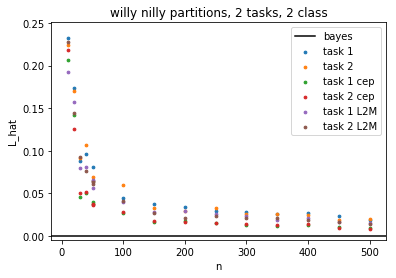

In [5]:
fig, ax = plt.subplots(1,1)
ax.scatter(ns, mean_errors_X, s=7.5, label = 'task 1')
ax.scatter(ns, mean_errors_Z, s=7.5, label = 'task 2')

ax.scatter(ns, mean_errors_HHX, s=7.5, label = 'task 1 cep')
ax.scatter(ns, mean_errors_HHZ, s=7.5, label = 'task 2 cep')

# ax.scatter(ns, mean_errors_joint, s=7.5, label = 'silly willy nilly')

ax.scatter(ns, mean_errors_LLX, s=7.5, label = 'task 1 L2M')
ax.scatter(ns, mean_errors_LLZ, s=7.5, label = 'task 2 L2M')

ax.set_xlabel('n')
ax.set_ylabel('L_hat')
ax.set_title('willy nilly partitions, 2 tasks, 2 class')
ax.axhline(y = 0, c='k',label = 'bayes')
ax.legend()
plt.savefig('willy_nilly_no_swn.png')

In [ ]:
#- Code graveyard

def estimate_posteriors(c, data, labels, c_left=-10**6, c_right=10**6):
    unique_labels, label_counts = np.unique(labels)
    
    temp_idx = (data > c_left).astype(int) + (data < c_right).astype(int) == 2
    temp_data = data[temp_idx]
    temp_label = labels[temp_idx]
    
    unique_temp_labels, temp_label_counts = np.unique(temp_label)
    
    if len(unique_temp_labels) == 0:
        return label_counts[-1] / np.sum(label_counts)
    elif len(unique_temp_labels) == 2:
        return temp_label_counts[-1] / len(temp_label)
    elif unique_temp_labels[0] == 0:
        return 0
    else:
        return 1
    
def build_linear_classifier(c, train, labels, test, posteriors=False):
    #Assumes 1d
    #Assumes 2 classes
    #Assumes type(c) is array-like 
    c = np.sort(c)
    
    if train.ndim == 1:
        n = len(train)
        m = len(test)
        proj_train = train
        proj_test = test
#     elif train.ndim == 2:
#         n, d = train.shape
#         m, d = test.shape
        
#         proj_train = train @ u
#         proj_test = test @ u
#     else:
#         raise ValueError('bad')
        
    
    
    temp = train[train < c[0]]
    temp_labels = labels[train < c[0]]
    
    if len(temp) == 0:
        if posteriors:
            partition_posteriors[0] = 0.5
        else:
            partition_posteriors[0] = np.random.binomial(1, 0.5)
    else:
        unique_, counts_ = np.unique(temp_labels, return_counts=True)
        if posteriors:
            partition_posteriors[0] = counts_[np.where(unique_ == 1)[0][0]]/np.sum(counts_)
        else:
            partition_posteriors[0] = unique_[np.argmax(counts_)]
    
    for i in range(1, len(c)):
        temp_idx = ((train < c[i]).astype(int) + (train > c[i-1]).astype(int)) == 2
        temp = train[temp_idx]
        temp_labels = labels[temp_idx]
        
        if len(temp) == 0:
            if posteriors:
                partition_posteriors[0] = 0.5
            else:
                partition_posteriors[i] = np.random.binomial(1, 0.5)
            
        else:
            unique_, counts_ = np.unique(temp_labels, return_counts=True)
            partition_posteriors[i] = unique_[np.argmax(counts_)]
            
            if posteriors:
                partition_posteriors[i] = counts_[np.where(unique_ == 1)[0][0]]/np.sum(counts_)
            else:
                partition_posteriors[i] = unique_[np.argmax(counts_)]
            
    temp = train[train > c[-1]]
    temp_labels = labels[train > c[-1]]
    
    if len(temp) == 0:
        if posteriors:
                partition_posteriors[0] = 0.5
        else:
            partition_posteriors[i] = np.random.binomial(1, 0.5)
    else:
        unique_, counts_ = np.unique(temp_labels, return_counts=True)
        if posteriors:
            partition_posteriors[-1] = counts_[np.where(unique_ == 1)[0][0]]/np.sum(counts_)
        else:
            partition_posteriors[-1] = unique_[np.argmax(counts_)]

    # Now, classify test observations    
    predictions = -1*np.ones(m)
    
    partitions = np.sum([np.array(test > c_) for c_ in c], axis=0)
    for i, c_ in enumerate(c):
        predictions[np.where(partitions == i)] = partition_posteriors[i]
        
    predictions[predictions == -1] = partition_posteriors[-1]
    
    return predictions